# Goal:

* Implement Tier-1 (ResNet-50, ResNet-101, ResNet-152) and Tier-2 (ResNet-18, ResNet-34) Resnets From Scratch.
* Train it on Garbage Classification Data for Classification Task.
* Compare the Classification performance with Standard PyTorch-ResNets for Garbage Classification.

## Additional Information:

* Output Shape of the Conv. Layer = **[(W−K+2P)/S]+1**
* **Convolutional Layer** : It is a linear operation that involves the multiplication of a set of weights with the input. 
* **Pooling** : Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. 
* **BatchNorm** : Handles the Covariate shift (the change of input distribution of the data) of the intermediate layers + Adds the slight regularizing effect.(Since mean and variance only calculated w.r.t mini-batch instead of the entire dataset.)
* **ReLU** : Speed up training, Gradient calculation is simple. (0 or 1 depending on the sign of the input), Computationally less expansive, Solves the Vanishing Gradient Problem.

### Residual Block: 

ResNet uses a technic called **Residual** to deal with the **vanishing gradient problem**. When stacking layers, we can use a **shortcut** to link discontinuous layers. i.e., We can skip some layers, as follows.

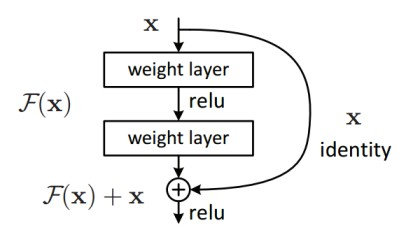

### References : 
1. [Implement ResNet with PyTorch](https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448)
2. [aladdinpersson
](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_resnet.py)
3. [TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
# Import Useful Modeules.
import torch
from torch import nn

## Tier-2 Resnets:

1. Resnet-18
2. Resnet-34

* We will first implement the Tier-2 Resnets since they are comparatively easy to implement. (few layers in one Residual Block + Constant kernel size throughout the Architecture)

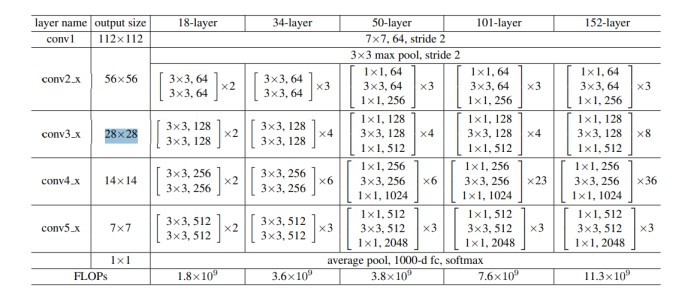

In [2]:
# Tier-2 ResBlock class. (Resnet-18,Resnet-34)
class ResBlock_Tier2(nn.Module):
    
    def __init__(self, in_channels, intermediate_channels):
        super(ResBlock_Tier2, self).__init__()
        
        # Layers
        # To make the residual input equal size as output channel.
        
        downsample = False
        self.skip_connection = nn.Sequential() # Default
        
        if intermediate_channels == 2*in_channels:
            self.skip_connection = nn.Sequential(nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=2, bias = False),
                                             nn.BatchNorm2d(intermediate_channels)
                                            )
            downsample = True
            

        
        # Downsampling the output shape.
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=2, padding = 1, bias = False)
            
        else:
            self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=1, padding = 1, bias = False)
            
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        # Residual to be added later.
        identity = self.skip_connection(x)
        
        #---------------------------
        # Layer-1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #----------------------------
        
        #---------------------------
        # Layer-2
        x = self.conv2(x)
        x = self.bn2(x)
        #print(x.size())
        #print(identity.size())
        x += identity
        x = self.relu(x)
        #----------------------------
        
        return x
    
#---------------------------------------------------------------------------------------------------
'''
  This is Tier-2 Resnet class (Resnet-18, 34)
  It takes input as img_channels:
  for RGB = 3
  for Gray = 1),
  
  num_layers: 
  for Resnet-18 = [2, 2, 2, 2]
  for Resnet-34 = [3, 4, 6, 3]
  
  , and number of classes. 
  for ex : Imagenet = 1000, MNIST = 10 etc
  
  Output : Resnet Model
  
'''
class ResNet_Tier2(nn.Module):
    
    def __init__(self, img_channels, num_layers, num_classes):
        super(ResNet_Tier2, self).__init__()
        
        # Layers 
        # Layer-0 Output shape : 64 X 56 X 56
        self.layer0 = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # Residual Blocks layers
        self.layer1 = self._make_layer(ResBlock_Tier2, num_layers[0], 64, 64)
        self.layer2 = self._make_layer(ResBlock_Tier2, num_layers[1], 64, 128)
        self.layer3 = self._make_layer(ResBlock_Tier2, num_layers[2], 128, 256)
        self.layer4 = self._make_layer(ResBlock_Tier2, num_layers[3], 256, 512)
        
        # FC Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc  = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock_Tier2, num_residual_blocks, in_channels, intermediate_channels):
        
        layers = []
        only_once = True
        
        for i in range(num_residual_blocks):
            layers.append(ResBlock_Tier2(in_channels, intermediate_channels))
            if only_once:
                in_channels = intermediate_channels
                only_once = False
            
        return nn.Sequential(*layers)

In [3]:
# Tier-2 Resnets.
def ResNet18(img_channel=3, num_classes=1000):
    return ResNet_Tier2(img_channel, [2, 2, 2, 2], num_classes)


def ResNet34(img_channel=3, num_classes=1000):
    return ResNet_Tier2(img_channel, [3, 4, 6, 3], num_classes)

In [4]:
# Test
def test():
    net = ResNet34(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cpu")
    print(y.size())
    
test()

torch.Size([4, 1000])


## Tier-1 Resnets:

1. Resnet-50
2. Resnet-101
3. Resnet-152

In [5]:
# Tier-1 ResBlock class. (Resnet-50, Resnet-101, Resnet-152)
class ResBlock_Tier1(nn.Module):
    
    def __init__(self, in_channels, intermediate_channels):
        super(ResBlock_Tier1, self).__init__()
        
        # Layers
        # To make the residual input equal size as output channel.
        
        stride = 1 # Default value
        downsample = False
        
        if intermediate_channels == in_channels/2:
            stride = 2
            downsample = True
            
        self.skip_connection = nn.Sequential(nn.Conv2d(in_channels, intermediate_channels*4, kernel_size=1, stride=stride, bias = False),
                                             nn.BatchNorm2d(intermediate_channels*4)
                                            )
        
        # Downsampling the output shape.
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=2, bias = False)
            
        else:
            self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, bias = False)
            
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels*4, kernel_size=1, stride=1, bias = False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels*4)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        # Residual to be added later.
        identity = self.skip_connection(x)
        
        #---------------------------
        # Layer-1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #----------------------------
        
        #---------------------------
        # Layer-2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        #----------------------------
        
        #---------------------------
        # Layer-3
        x = self.conv3(x)
        x = self.bn3(x)
        #print("Size identity", identity.size())
        #print("Size X", x.size())
        x += identity
        x = self.relu(x)
        #----------------------------
        
        return x
    
#---------------------------------------------------------------------------------------------------
'''
  This is Tier-1 Resnet class (Resnet-50, 101, 152)
  It takes input as img_channels:
  for RGB = 3
  for Gray = 1),
  
  num_layers: 
  for Resnet-50 = [3, 4, 6, 3]
  for Resnet-101 = [3, 4, 23, 3]
  for Resnet-152 = [3, 8, 36, 3]
  
  , and number of classes. 
  for ex : Imagenet = 1000, MNIST = 10 etc
  
  Output : Resnet Model
  
'''
class ResNet_Tier1(nn.Module):
    
    def __init__(self, img_channels, num_layers, num_classes):
        super(ResNet_Tier1, self).__init__()
        
        # Layers 
        # Layer-0 Output shape : 64 X 56 X 56
        self.layer0 = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # Residual Blocks layers
        self.layer1 = self._make_layer(ResBlock_Tier1, num_layers[0], 64, 64)
        self.layer2 = self._make_layer(ResBlock_Tier1, num_layers[1], 256, 128)
        self.layer3 = self._make_layer(ResBlock_Tier1, num_layers[2], 512, 256)
        self.layer4 = self._make_layer(ResBlock_Tier1, num_layers[3], 1024, 512)
        
        # FC Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc  = nn.Linear(512 * 4, num_classes)
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock_Tier1, num_residual_blocks, in_channels, intermediate_channels):
        
        layers = []
        only_once = True
        
        for i in range(num_residual_blocks):
            layers.append(ResBlock_Tier1(in_channels, intermediate_channels))
            if only_once:
                in_channels = intermediate_channels*4
                only_once = False
            
        return nn.Sequential(*layers)

In [6]:
# Tier-1 Resnets.
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet_Tier1(img_channel, [3, 4, 6, 3], num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet_Tier1(img_channel, [3, 4, 23, 3], num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet_Tier1(img_channel, [3, 8, 36, 3], num_classes)

In [7]:
# Test
def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cpu")
    print(y.size())
    
test()

torch.Size([4, 1000])


# Garbage Classification

1. Data Analysis
2. Data Visualization
3. Data Prepration
4. Training with **Standard PyTorch Resnets**
5. Training with **Our Resnets**
6. Performance Comparison

## Data Analysis

In [8]:
# Import useful modules.
import os, shutil, random
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
# Image DIR PATH
SRC = '../input/garbage-classification/Garbage classification/Garbage classification'
os.listdir(SRC)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']

In [10]:
DATA_DISTRIBUTION = {}

for file in os.listdir(SRC):
    DATA_DISTRIBUTION[f'{file}'] = len(os.listdir(os.path.join(SRC, file)))
    
# Total Data Distribution.
DATA_DISTRIBUTION

{'metal': 410,
 'glass': 501,
 'paper': 594,
 'trash': 137,
 'cardboard': 403,
 'plastic': 482}

[Text(0, 0, '410'),
 Text(0, 0, '501'),
 Text(0, 0, '594'),
 Text(0, 0, '137'),
 Text(0, 0, '403'),
 Text(0, 0, '482')]

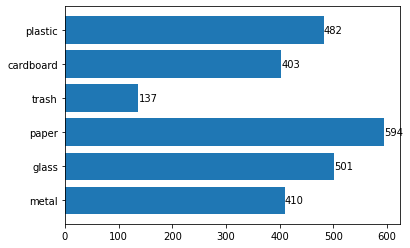

In [11]:
# Data Distribution
fig, ax = plt.subplots()
bars = ax.barh(list(DATA_DISTRIBUTION.keys()), list(DATA_DISTRIBUTION.values()))

ax.bar_label(bars)

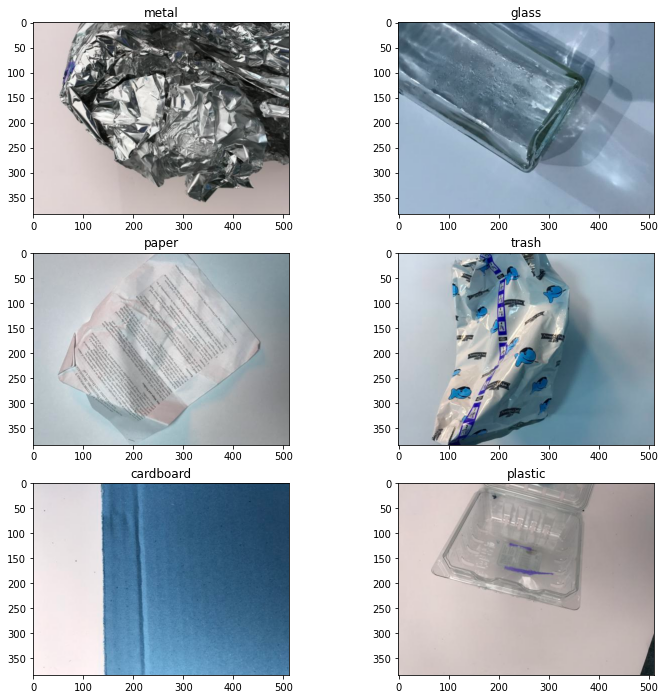

In [12]:
# Randomly Visualizing the samples.
imgs = []
classes = []
for file in os.listdir(SRC):
    temp = os.path.join(SRC, file)
    sample = random.choice(os.listdir(temp))
    img = cv2.imread(os.path.join(temp, sample))
    imgs.append(img)
    classes.append(file)
    
f, ax = plt.subplots(3, 2, figsize = (12, 12))

cnt = 0
for i in range(3):
    ax[i, 0].imshow(imgs[cnt])
    ax[i, 0].set_title(classes[cnt])
    ax[i, 1].imshow(imgs[cnt + 1])
    ax[i, 1].set_title(classes[cnt+1])
    cnt += 2

## Data Preparation

In [26]:
# Data Preparation.
f_train = open("../input/garbage-classification/one-indexed-files-notrash_train.txt", "r")
f_val = open("../input/garbage-classification/one-indexed-files-notrash_val.txt", "r")
f_test = open("../input/garbage-classification/one-indexed-files-notrash_test.txt", "r")

df_train = pd.DataFrame(columns = ['fname', 'label'])
df_val = pd.DataFrame(columns = ['fname', 'label'])
df_test = pd.DataFrame(columns = ['fname', 'label'])

for x in f_train:
    fname, label = x[:-1].split(' ')
    temp = {'fname' : fname, 'label' : int(label)-1}
    df_train = df_train.append(temp, ignore_index = True)

for x in f_val:
    fname, label = x[:-1].split(' ')
    temp = {'fname' : fname, 'label' : int(label)-1}
    df_val = df_val.append(temp, ignore_index = True)

for x in f_test:
    fname, label = x[:-1].split(' ')
    temp = {'fname' : fname, 'label' : int(label)-1}
    df_test = df_test.append(temp, ignore_index = True)

len(df_train), len(df_val), len(df_test)     

(1768, 328, 431)

## Helper functions

In [27]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import re

# Datset Class
class GarbageCollectionDataset(Dataset):
    
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        
        class_name = re.findall(r'(\w+?)(\d+)', self.annotations.iloc[index, 0])[0][0]
        img_path =  os.path.join(self.root_dir, class_name, self.annotations.iloc[index, 0])
        img = Image.open(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        return (img, label)
    
#----------------------------------------------------------------------------------------------------

import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
#-------------------------------------------------------------------------------------------------------

# Model Performance on test data
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    
    # Now set model to validation mode.
    running_loss = 0
    running_accuracy = 0
    
     # Processing the Test Loader
    for (inputs, labels) in dataloader:
        
        # Load data to device.
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Loss and Backpropagation.
        loss = criterion(outputs, labels)
        
        # Statistics
        running_loss += loss.item()*inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss/size_of_dataset
    epoch_accuracy = running_accuracy/size_of_dataset
    
    return epoch_loss, epoch_accuracy

#------------------------------------------------------------------------------------------------
import copy

def train(model, criterion, optimizer, scheduler, num_of_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #track_training_loss = []
    #track_val_loss = []

    for epoch in range(num_of_epochs):

        print(f'\nEpoch {epoch + 1}/{num_of_epochs}')
        print('-'*30)

        model.train() # Setting model to train.
        running_loss = 0
        running_accuracy = 0

        # Processing the Train Loader
        for (inputs, labels) in train_loader:

            # Load data to device.
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients

            # Outputs
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)

            # Loss and Backpropagation.
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()*inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss/len(train_dataset)
        epoch_accuracy = running_accuracy/len(train_dataset)
        #track_training_loss.append(epoch_loss) # Loss Tracking

        print(f'Training Loss: {epoch_loss:.4f} Training Acc.: {epoch_accuracy:.4f}')

        # Now set model to validation mode.
        model.eval()

        val_loss, val_accuracy = calculate_loss_and_accuracy(model, val_loader, len(val_dataset), criterion)

        if val_accuracy > best_acc:
            print("Found better model...")
            print('Updating the model weights....\n')
            print(f'Val Loss: {val_loss:.4f} Val Acc.: {val_accuracy:.4f}\n')

            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
     
    model.load_state_dict(best_model_wts) # update model
    
    return  model

In [28]:
# Hyper-params
BATCH_SIZE = 64
device = torch.device('cuda')

# Data Prepration.
from torchvision import transforms
from torch.utils.data import DataLoader

# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Dataset.
train_dataset = GarbageCollectionDataset(df = df_train, root_dir = SRC, transform = data_transforms['train'])
val_dataset = GarbageCollectionDataset(df = df_val, root_dir = SRC, transform = data_transforms['val'])
test_dataset = GarbageCollectionDataset(df = df_test, root_dir = SRC, transform = data_transforms['val'])

# Datloaders
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

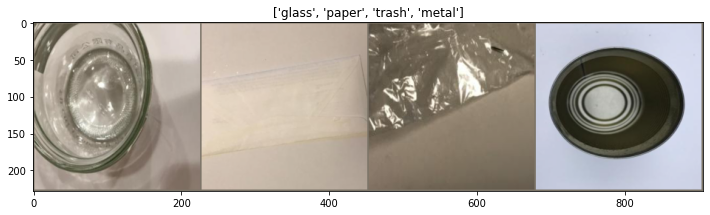

In [44]:
class_names = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
data_loader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True)
inputs, classes = next(iter(data_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Standard Pytorch Resnet-18

In [50]:
# Pytorch Standard Resnet-18 Model.
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
# change num of classes to 6
model.fc = nn.Linear(num_ftrs, 6)
model = model.to(device) # Load model to device.

# Criterion.
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

NUM_OF_EPOCHS = 30

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )


Epoch 1/30
------------------------------
Training Loss: 1.6466 Training Acc.: 0.3088
Found better model...
Updating the model weights....

Val Loss: 1.6684 Test Acc.: 0.3079


Epoch 2/30
------------------------------
Training Loss: 1.4476 Training Acc.: 0.4355
Found better model...
Updating the model weights....

Val Loss: 1.4136 Test Acc.: 0.4482


Epoch 3/30
------------------------------
Training Loss: 1.3466 Training Acc.: 0.4802

Epoch 4/30
------------------------------
Training Loss: 1.2928 Training Acc.: 0.5011
Found better model...
Updating the model weights....

Val Loss: 1.2859 Test Acc.: 0.5335


Epoch 5/30
------------------------------
Training Loss: 1.2409 Training Acc.: 0.5260

Epoch 6/30
------------------------------
Training Loss: 1.2040 Training Acc.: 0.5402

Epoch 7/30
------------------------------
Training Loss: 1.1598 Training Acc.: 0.5617
Found better model...
Updating the model weights....

Val Loss: 1.1859 Test Acc.: 0.5518


Epoch 8/30
-------------------

In [51]:
best_model.eval()
test_loss, test_accuracy = calculate_loss_and_accuracy(best_model, test_loader, len(test_dataset), criterion)
print(f'Test Loss : {test_loss: .4f} \nTest Accuracy : {test_accuracy: .4f}')

Test Loss :  1.0387 
Test Accuracy :  0.6148


## Our Resnet-18

In [48]:
# Our Resnet Model
model = ResNet18(img_channel=3, num_classes=6)
model = model.to(device) # Load model to device.

# Criterion.
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )


Epoch 1/30
------------------------------
Training Loss: 1.5681 Training Acc.: 0.3620
Found better model...
Updating the model weights....

Val Loss: 1.5489 Test Acc.: 0.3598


Epoch 2/30
------------------------------
Training Loss: 1.2764 Training Acc.: 0.5158
Found better model...
Updating the model weights....

Val Loss: 1.1856 Test Acc.: 0.5762


Epoch 3/30
------------------------------
Training Loss: 1.1780 Training Acc.: 0.5475
Found better model...
Updating the model weights....

Val Loss: 1.1450 Test Acc.: 0.6037


Epoch 4/30
------------------------------
Training Loss: 1.1085 Training Acc.: 0.5809

Epoch 5/30
------------------------------
Training Loss: 1.1083 Training Acc.: 0.5730
Found better model...
Updating the model weights....

Val Loss: 1.1063 Test Acc.: 0.6341


Epoch 6/30
------------------------------
Training Loss: 1.0138 Training Acc.: 0.6273

Epoch 7/30
------------------------------
Training Loss: 0.9845 Training Acc.: 0.6369

Epoch 8/30
-------------------

In [49]:
best_model.eval()
test_loss, test_accuracy = calculate_loss_and_accuracy(best_model, test_loader, len(test_dataset), criterion)
print(f'Test Loss : {test_loss: .4f} \nTest Accuracy : {test_accuracy: .4f}')

Test Loss :  0.7678 
Test Accuracy :  0.7193


## Comparison:

**Pytorch Standard Resnet-18**:

1. Validation Accuracy: **0.6159**
2. Test Accuracy: **0.6148**

**Our Resnet-18**:

1. Validation Accuracy: **0.7591**
2. Test Accuracy: **0.7193**

----------------------------------------------------------------------------------------------